In this script, we will analyze the connection between spending and voter turnout, as well as generally analyze turnout level on election results.

Let's get/initialize a spark session and then read in the `data/merged_data.csv`

In [18]:
from pyspark.sql import functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col
import os, re
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

spark = SparkSession.builder.appName("MunicipalSpendingAndElectionAnalysis").getOrCreate()

# load a merged CSV file into spark
merged_data = spark.read.csv("data/merged_data.csv", header=True, inferSchema=True)

First, we will analyze the correlation between education spending and voter turnout & party preference

At first, let's dynamically get the election years.

In [2]:
years = []
# iterate through XLSX files in folder
for filename in os.listdir("data"):
    if filename.endswith(".xlsx"):
        match = re.compile(r'\d{4}').search(filename) # match years in filenames
        if match:
            years.append(int(match.group()))

years.sort()

In [9]:
merged_data = merged_data.withColumn("Wahlbeteiligung", col("Wahlbeteiligung").cast("float"))

# aggregate data per municipality
# average turnout per municipality
voter_turnout = merged_data.groupBy("Municipality_Lowercase") \
    .agg(F.avg("Wahlbeteiligung").alias("Avg_Turnout"))

# average edu spending % per municipality
edu_pct = merged_data.groupBy("Municipality_Lowercase") \
    .agg(F.avg("Edu_Spending_Percentage").alias("Avg_Edu_Spending_Percentage"))

# average edu spending per capita per municipality
edu_pc = merged_data.groupBy("Municipality_Lowercase") \
    .agg(F.avg("Education_Spending_PC").alias("Avg_Education_Spending_PC"))

# total party wins per municipality
# Note: if every municipality has the same number of elections, variation will be limited.
total_wins = merged_data.groupBy("Municipality_Lowercase") \
    .agg(F.count("Winning_Party").alias("Win_Count"))

# Join the aggregates
data_pct_vs_turnout = edu_pct.join(voter_turnout, on="Municipality_Lowercase")
data_pc_vs_turnout = edu_pc.join(voter_turnout, on="Municipality_Lowercase")
data_pct_vs_wins = edu_pct.join(total_wins, on="Municipality_Lowercase")
data_pc_vs_wins = edu_pc.join(total_wins, on="Municipality_Lowercase")

# -----------------------------
# 4. Compute correlations (using aggregated data)
correlation_edu_pct_turnout = data_pct_vs_turnout.stat.corr("Avg_Edu_Spending_Percentage", "Avg_Turnout")
correlation_edu_pc_turnout = data_pc_vs_turnout.stat.corr("Avg_Education_Spending_PC", "Avg_Turnout")
correlation_edu_pct_wins = data_pct_vs_wins.stat.corr("Avg_Edu_Spending_Percentage", "Win_Count")
correlation_edu_pc_wins = data_pc_vs_wins.stat.corr("Avg_Education_Spending_PC", "Win_Count")

print(f"\nCorrelation (Edu Spending Percentage vs. Voter Turnout): {correlation_edu_pct_turnout:.3f}")
print(f"Correlation (Education Spending Per Capita vs. Voter Turnout): {correlation_edu_pc_turnout:.3f}")
print(f"\nCorrelation (Edu Spending Percentage vs. Party Wins): {correlation_edu_pct_wins:.3f}")
print(f"Correlation (Education Spending Per Capita vs. Party Wins): {correlation_edu_pc_wins:.3f}\n")



Correlation (Edu Spending Percentage vs. Voter Turnout): -0.148
Correlation (Education Spending Per Capita vs. Voter Turnout): -0.275

Correlation (Edu Spending Percentage vs. Party Wins): -0.068
Correlation (Education Spending Per Capita vs. Party Wins): 0.081



Spending vs. voter turnout correlation is weak and negative.

Possible explanations:
- Voter turnout may be driven by other factors, not just spending.
- Higher spending may be happening in areas with historically low turnout, i.e. it’s compensating for something else (like economic hardship).
- Public spending could be taken for granted, so people don't vote based on it.

Recent spending shows almost the same correlation as total spending, which suggests that spending patterns over time do not significantly shift voter participation.

Spending vs. party wins correlation is weak and positive.

Possible explanations:
- Winning parties may influence spending, rather than the other way around.
    - If a party keeps winning in the same municipalities, they may maintain/increase spending in their strongholds.
    - This would make spending a result of party wins rather than a cause.
- Voters may not directly connect public spending to election results.
    - Spending benefits may be distributed across multiple parties, making it hard to attribute changes to one party’s success.
    - If voters might see education spending as a government duty rather than a political strategy.

Recent spending has almost the same correlation as total spending, which suggests that spending in the short term isn’t much more influential than long-term trends.

Overall, spending has a weak direct linear correlation with voter turnout and party wins, meaning it’s not the main factor affecting elections.

However, in the predictive models, we saw that the total spending feature is important, suggesting it interacts with other variables in nonlinear ways. Spending may still play a role in influencing elections, but it likely works indirectly.

Next, we will produce two visualizations to help us understand the data better. We will try to make this as scalable as possible.

However, while pyspark handles data processing, visualization requires conversion to Pandas (for rendering).

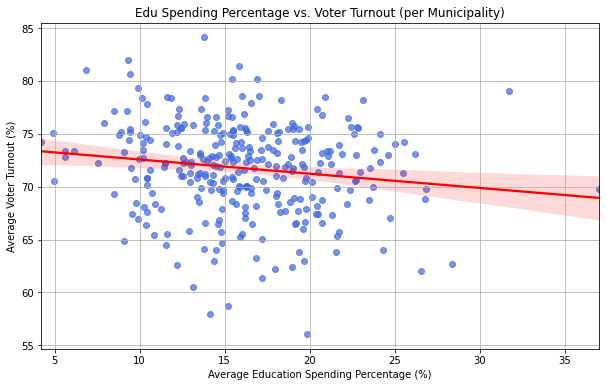

In [20]:
# convert data to Pandas for visualization
data_pct_pdf = data_pct_vs_turnout.toPandas() # %
data_pc_pdf = data_pc_vs_turnout.toPandas() # per capita
wins_pdf = total_wins.toPandas()
merged_pdf = merged_data.toPandas()

# edu spending % vs. voter turnout
plt.figure(figsize=(10, 6))
sns.regplot(data=data_pct_pdf, x="Avg_Edu_Spending_Percentage", y="Avg_Turnout", 
            color="royalblue", scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.xlabel("Average Education Spending Percentage (%)")
plt.ylabel("Average Voter Turnout (%)")
plt.title("Edu Spending Percentage vs. Voter Turnout (per Municipality)")
plt.grid(True)
plt.show()

There is a slight negative correlation. Data is scattered, indicating that education spending / total spending per capita ratio might not be a strong predictor of voter turnout.

The negative slope suggests that higher relative per capita spending on education does not necessarily lead to higher voter turnout. This could indicate that regions with high education spending might already have stable participation rates, or other socio-political factors influence turnout more.

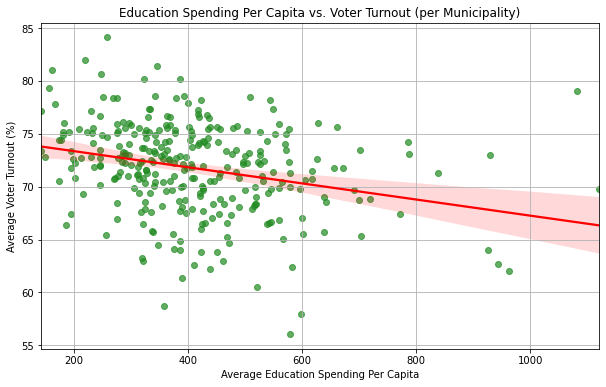

In [21]:
# education spending per capita vs. voter turnout
plt.figure(figsize=(10, 6))
sns.regplot(data=data_pc_pdf, x="Avg_Education_Spending_PC", y="Avg_Turnout", 
            color="forestgreen", scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.xlabel("Average Education Spending Per Capita")
plt.ylabel("Average Voter Turnout (%)")
plt.title("Education Spending Per Capita vs. Voter Turnout (per Municipality)")
plt.grid(True)
plt.show()

Interestingly, negative correlation again. The pattern is similar to the first graph's no strong clustering, meaning other variables might play a stronger role in predicting turnout.

This suggests that simply spending more on education does not directly lead to more political engagement (higher voter turnout). High-education-spending municipalities may already have higher civic engagement, making additional spending marginally ineffective, or, simply, other economic or demographic factors are at play.


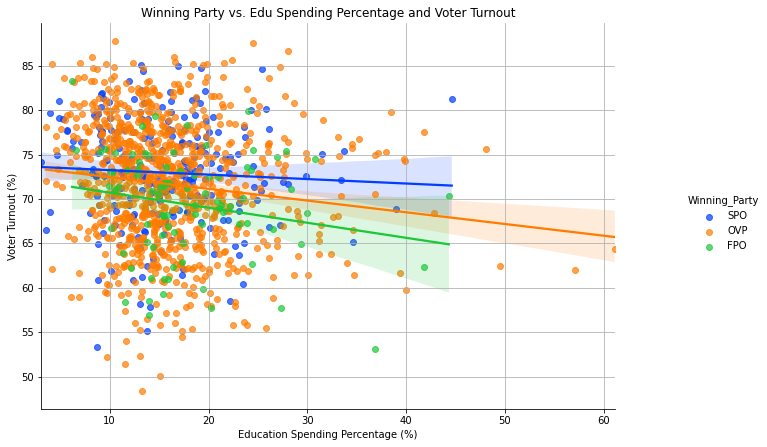

In [22]:
# winning party vs. edu spending % and turnout
g = sns.lmplot(data=merged_pdf, x="Edu_Spending_Percentage", y="Wahlbeteiligung", 
               hue="Winning_Party", palette="bright", scatter_kws={"alpha": 0.7})
g.fig.set_size_inches(11, 6)
plt.xlabel("Education Spending Percentage (%)")
plt.ylabel("Voter Turnout (%)")
plt.title("Winning Party vs. Edu Spending Percentage and Voter Turnout")
plt.grid(True)

- SPÖ (blue) and ÖVP (orange) have a broad distribution across education spending and turnout.
- FPÖ (green) tends to be relatively more concentrated in lower voter turnout regions.
- SPÖ has an almost flat trendline, suggesting education spending % does not significantly impact their voter turnout.
- ÖVP's, and more strongly FPÖ's downward trend suggests that higher education spending percentage leads to slightly lower voter turnout.
- FPÖ benefits more from low-turnout areas, reinforcing its populist/anti-establishment appeal among disengaged voters, as well as the negative trendline aligns with the party's anti-establishment sentiments.
- ÖVP hase a broader voter base, so education spending percentage alone is not a defining factor in their success.

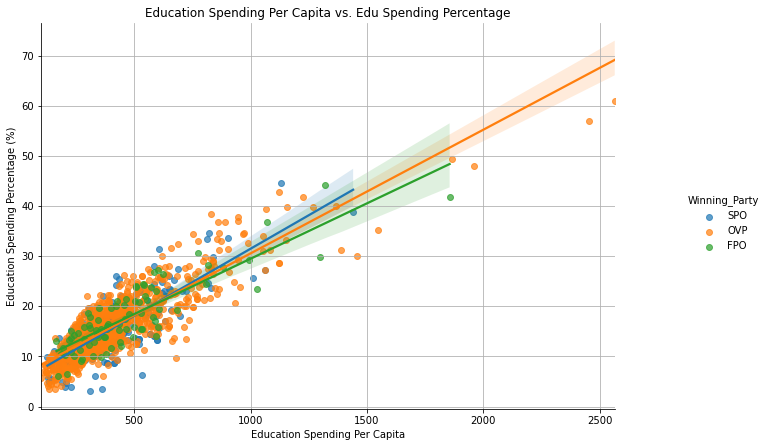

In [23]:
# education spending per capita vs. education spending %
g = sns.lmplot(data=merged_pdf, x="Education_Spending_PC", y="Edu_Spending_Percentage", 
               hue="Winning_Party", palette="tab10", scatter_kws={"alpha": 0.7})
g.fig.set_size_inches(11, 6)
plt.xlabel("Education Spending Per Capita")
plt.ylabel("Education Spending Percentage (%)")
plt.title("Education Spending Per Capita vs. Edu Spending Percentage")
plt.grid(True)

Expected strong correlation, since total spending influences per capita spending. The trendlines for the 3 parties are roughly even, which suggests that there aren't much party-specific differences in how education is spent in the municipality.

Regions with high absolute education spending per capita also allocate a larger share of their total spending to education, which is expected.

The values are tightly clustered. This might suggest that education funding policies in these municipalities follow a standardized pattern. Municipalities might have limited flexibility in drastically increasing or decreasing education budgets due to legal requirements and financial constraints.

Additionally, most municipalities have similar baseline education costs (teacher salaries, school maintenance, materials), and since public education is mostly state-funded, funding levels tend to scale predictably with population size rather than varying dramatically.

Furthermore, obviously, local governments cannot allocate an unlimited portion of their budget to education because they also need to fund healthcare, public transport, infrastructure, and social services.

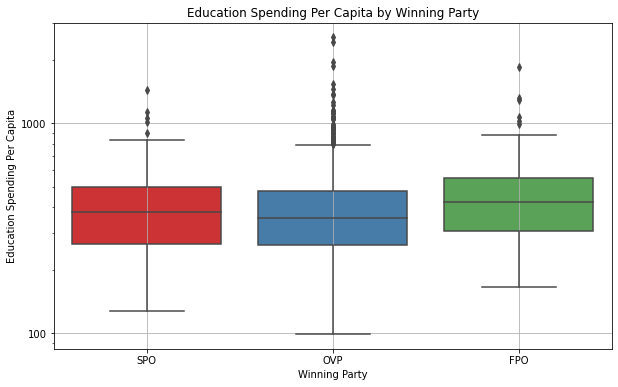

In [26]:
# education spending per capita vs. winning party
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_pdf, x="Winning_Party", y="Education_Spending_PC", palette="Set1")
plt.yscale("log")
plt.xlabel("Winning Party")
plt.ylabel("Education Spending Per Capita")
plt.title("Education Spending Per Capita by Winning Party")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.0f}"))  # no scientific notation
plt.show()

This boxplot shows that SPÖ, ÖVP, and FPÖ have fundamentally similar spending levels. Median is roughly consistent, upper and lower quantiles are also roughly consistent, also for FPÖ, both are slighly higher. However, this most difference is small and likely does not indicate anything meaningful.

Slighly more interesting is that ÖVP has shows the largest distribution of values. It won the lowest per capita education spending municipality and also the highest per capita spending ones as well. Additionally, the boxplot shows that ÖVP won by far the most (upper) outliers of education spending per capita.

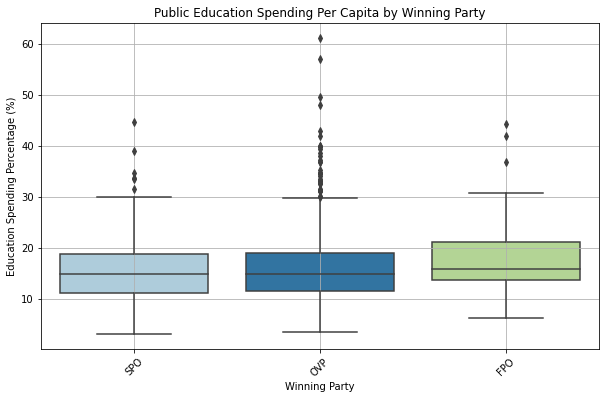

In [30]:
# public spending % by winning party
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_pdf, x="Winning_Party", y="Edu_Spending_Percentage", palette="Paired")
plt.xlabel("Winning Party")
plt.ylabel("Education Spending Percentage (%)")
plt.title("Public Education Spending Per Capita by Winning Party")
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.0f}"))  # no scientific notation
plt.show()

Similarly to the previous boxplot, median, as well as upper and lower quantiles do not differ in a significant, meaningful way. Also similar to the previous boxplot is that while all 3 major parties seem to win upper outliers, ÖVP wins them by far the most, as well as wins those specific municiaplities that have the highest education spending percentage. 

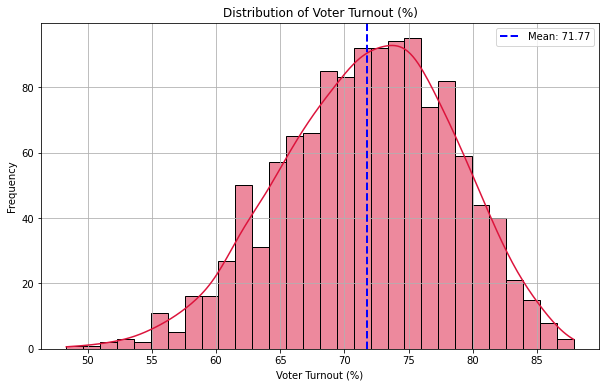

Skewness: -0.2902


In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_pdf["Wahlbeteiligung"], kde=True, bins=30, color="crimson")
mean_value = merged_pdf["Wahlbeteiligung"].mean()
plt.axvline(mean_value, color="blue", linestyle="dashed", linewidth=2, label=f"Mean: {mean_value:.2f}")
plt.xlabel("Voter Turnout (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Voter Turnout (%)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Skewness: {merged_pdf['Wahlbeteiligung'].skew():.4f}")

Slightly left skewed distribution. Mean is around 72%, peak frequency is around 75%.

While Upper Austria's voter turnout distribution appears relatively balanced, it is not perfectly *normal*. There are more municipalities with extremely low turnout than those with extremely high turnout. While turnout values slightly below or above the mean are roughly consistent, the distribution has a heavier left tail.

As we see, the skewness is negative (-0.29), indicating a left skew.

In [5]:
spark.stop()